### Урок 2. 

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 31.2 s, sys: 517 ms, total: 31.7 s
Wall time: 33 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 52s, sys: 2.33 s, total: 3min 54s
Wall time: 4min 13s


In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [14]:
common_dictionary[2]

'алексей'

In [15]:
from gensim.models import LdaModel

In [16]:
%%time
#from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 50.7 s, sys: 2.82 s, total: 53.5 s
Wall time: 36.7 s


In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:4]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[3])
lda[unseen_doc] 

['главный', 'тренер', 'кубань', 'юрий', 'красножанин', 'прокомментировать', 'победа', 'крыло', 'совет', 'nn', 'матч', 'го', 'тур', 'чемпионат', 'россия', 'nn', 'второй', 'игра', 'подряд', 'получиться', 'заработать', 'преимущество', 'успокаиваться', 'передавать', 'сэ', 'пока', 'осложнить', 'жизнь', 'спокойствие', 'пребывать', 'наверное', 'конец', 'сезон', 'понемногу', 'отпускной', 'настроение', 'овладевать', 'игрок', 'менее', 'смочь', 'состояние', 'создать', 'немало', 'момент', 'целое', 'всё', 'неплохо', 'привыкать', 'команда', 'статус', 'лидер', 'наверное', 'команда', 'действительно', 'уверенно', 'чувствовать', 'возможно', 'частично', 'отсюда', 'идти', 'самоуспокоенность', 'вести', 'счёт', 'почему', 'выпустить', 'афолаби', 'первый', 'попасть', 'заявка', 'заменить', 'бальда', 'здорово', 'отыграть', 'хотеть', 'дать', 'закончить', 'матч', 'заменить', 'попов', 'требоваться', 'всё', 'замена', 'позиция']


[(20, 0.25241438), (22, 0.13355996), (23, 0.21617624), (24, 0.375506)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=8,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: новый обнаружить эксперт nn писать цена двигатель британский
topic_1: научный статья исследование источник nn проверка законодательство оборудование
topic_2: военный государство удар россия действие чёрный боевой вицепремьер
topic_3: операция произойти область район территория тыс пациент исследование
topic_4: млн составить экономика население поверхность пенсия рост место
topic_5: фестиваль топливо мальчик век смерть ремонт инженер израиль
topic_6: решение власть глава россия новый nn принять правительство
topic_7: товар способность теория производитель тепло звезда актёр прибыль
topic_8: ракета египет километр ночью пилотировать азия боевик террорист
topic_9: всё погибнуть система сторона проблема случай вопрос новый
topic_10: россия рынок российский тыс система цена земля объект
topic_11: бомба губернатор свердловский приземлиться екатеринбург нил аркадий близость
topic_12: газ восток турецкий турция агентство следователь обвинение источник
topic_13: сша nn станция северный

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.000000,0.0,0.098371,0.0,0.0,...,0.0,0.0,0.666046,0.000000,0.0,0.000000,0.0,0.000000,0.071807,0.000000
1,4896,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.347721,0.0,0.417615,0.0,0.000000,0.211476,0.000000
2,4897,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.252437,0.0,0.133527,0.216172,0.375521
3,4898,0.158212,0.0,0.0,0.0,0.059184,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.037341,0.000000,0.0,0.300157,0.0,0.435036,0.000000,0.000000
4,4899,0.000000,0.0,0.0,0.0,0.000000,0.0,0.160849,0.0,0.0,...,0.0,0.0,0.313055,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


### векторные представления пользователей

In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.1379772 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26744455, 0.08556213, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05770145, 0.        , 0.15732768, 0.04245067, 0.02020098,
       0.        , 0.        , 0.        , 0.2197964 , 0.        ])

In [25]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [26]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [27]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding_mean(user_articles_list)

array([0.01410473, 0.0033942 , 0.08355235, 0.08164613, 0.01624018,
       0.        , 0.20993289, 0.        , 0.00792505, 0.08638139,
       0.06560939, 0.        , 0.04399871, 0.02717387, 0.        ,
       0.00860711, 0.02539423, 0.1861034 , 0.        , 0.01411804,
       0.01064676, 0.        , 0.08305336, 0.01662897, 0.00230496])

In [29]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.02811075, 0.        , 0.        ,
       0.        , 0.16795005, 0.        , 0.        , 0.06371598,
       0.01493343, 0.        , 0.01593751, 0.        , 0.        ,
       0.        , 0.        , 0.21332529, 0.        , 0.        ,
       0.        , 0.        , 0.04720662, 0.        , 0.        ])

In [30]:
get_user_embedding_max(user_articles_list)

array([0.08462837, 0.02036519, 0.33026361, 0.45273656, 0.0974411 ,
       0.        , 0.51051092, 0.        , 0.03071054, 0.25198883,
       0.20283765, 0.        , 0.1603568 , 0.1014892 , 0.        ,
       0.05164263, 0.1074467 , 0.36570951, 0.        , 0.08470824,
       0.05083681, 0.        , 0.27608058, 0.05837996, 0.01382973])

In [31]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [32]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [33]:
# на средних 

user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.109453,0.029212,0.009117,0.098364,0.000000,0.023304,0.101352,0.019032,0.000000,...,0.113828,0.091014,0.040669,0.029488,0.003367,0.000000,0.000000,0.046794,0.107825,0.010118
1,u108690,0.046303,0.032622,0.038207,0.100702,0.009072,0.002209,0.161441,0.000000,0.000000,...,0.040127,0.054451,0.080372,0.025930,0.000000,0.020311,0.008905,0.082651,0.023301,0.007675
2,u108339,0.035495,0.012273,0.079188,0.224344,0.001775,0.004397,0.136804,0.014719,0.009124,...,0.029136,0.018772,0.064745,0.038140,0.033876,0.014164,0.000000,0.050480,0.044993,0.014236


In [34]:
# на медиане 

user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.068989,0.000000,0.000000,0.062052,0.0,0.0,0.092593,0.0,0.0,...,0.028851,0.056469,0.000000,0.021225,0.0,0.000000,0.0,0.00000,0.067762,0.000000
1,u108690,0.040306,0.023375,0.020203,0.047267,0.0,0.0,0.148451,0.0,0.0,...,0.036401,0.044388,0.088336,0.013367,0.0,0.000000,0.0,0.07341,0.010924,0.000000
2,u108339,0.032466,0.008543,0.072919,0.247538,0.0,0.0,0.119273,0.0,0.0,...,0.020589,0.008870,0.037703,0.034416,0.0,0.006751,0.0,0.01862,0.032508,0.005495


In [35]:
# на мексимуме 

user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.324600,0.145705,0.054700,0.293078,0.000000,0.095300,0.267445,0.085562,0.000000,...,0.455355,0.336589,0.157328,0.091271,0.020201,0.000000,0.000000,0.197068,0.291626,0.060706
1,u108690,0.100707,0.087381,0.112981,0.314253,0.054434,0.013254,0.326626,0.000000,0.000000,...,0.103008,0.142485,0.149436,0.086759,0.000000,0.066153,0.053428,0.187789,0.074165,0.046048
2,u108339,0.080864,0.028395,0.154050,0.299975,0.010651,0.015582,0.270850,0.065911,0.054743,...,0.083947,0.053443,0.156542,0.083345,0.172724,0.049939,0.000000,0.178892,0.104883,0.050923


3 датасета готовы

In [36]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


### Обучение модели на средних

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.109453,0.029212,0.009117,0.098364,0.000000,0.023304,0.101352,0.019032,0.000000,...,0.091014,0.040669,0.029488,0.003367,0.000000,0.000000,0.046794,0.107825,0.010118,0
1,u108690,0.046303,0.032622,0.038207,0.100702,0.009072,0.002209,0.161441,0.000000,0.000000,...,0.054451,0.080372,0.025930,0.000000,0.020311,0.008905,0.082651,0.023301,0.007675,1
2,u108339,0.035495,0.012273,0.079188,0.224344,0.001775,0.004397,0.136804,0.014719,0.009124,...,0.018772,0.064745,0.038140,0.033876,0.014164,0.000000,0.050480,0.044993,0.014236,1


In [39]:
#разделим данные на train/test
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [40]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_mean_train, y_mean_train)

LogisticRegression()

In [41]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_mean_test)[:, 1]
preds[:10]

array([0.15217595, 0.03239626, 0.2527801 , 0.2366156 , 0.05443942,
       0.02673068, 0.11946841, 0.04686596, 0.19393141, 0.13241475])

In [42]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [43]:
import itertools

In [44]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_mean_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

Best Threshold=0.874299, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-44-cfd7c8917d44>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)


In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


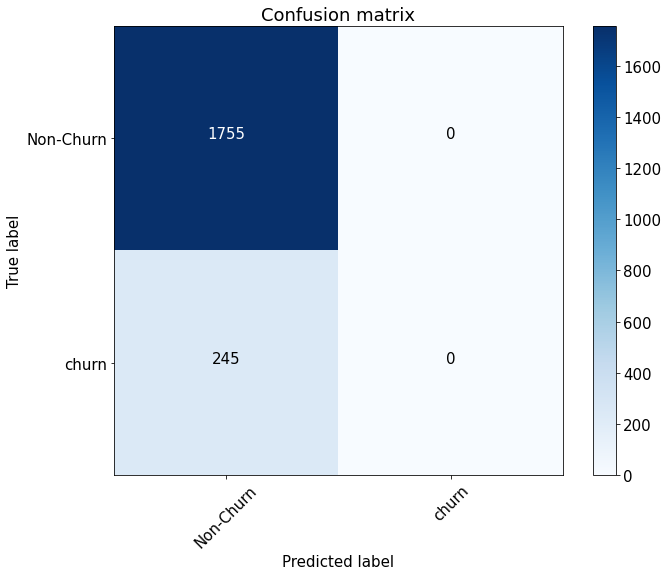

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_mean_test, preds>thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
roc_auc_score_mean = roc_auc_score(y_mean_test, preds)

In [48]:
roc_auc_score_mean

0.9466969009826153

### Обучение модели на медиане¶

In [49]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.068989,0.000000,0.000000,0.062052,0.0,0.0,0.092593,0.0,0.0,...,0.056469,0.000000,0.021225,0.0,0.000000,0.0,0.00000,0.067762,0.000000,0
1,u108690,0.040306,0.023375,0.020203,0.047267,0.0,0.0,0.148451,0.0,0.0,...,0.044388,0.088336,0.013367,0.0,0.000000,0.0,0.07341,0.010924,0.000000,1
2,u108339,0.032466,0.008543,0.072919,0.247538,0.0,0.0,0.119273,0.0,0.0,...,0.008870,0.037703,0.034416,0.0,0.006751,0.0,0.01862,0.032508,0.005495,1


In [50]:
#разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [51]:
#обучим 
logreg_median = logreg.fit(X_median_train, y_median_train)

In [52]:
#наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_median[:10]

array([0.13639843, 0.03486257, 0.54808083, 0.30774587, 0.01399461,
       0.0463661 , 0.08187307, 0.0984228 , 0.36251025, 0.08881679])

In [53]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.358624, F-Score=0.819, Precision=0.844, Recall=0.796


Confusion matrix, without normalization
[[1719   36]
 [  51  194]]


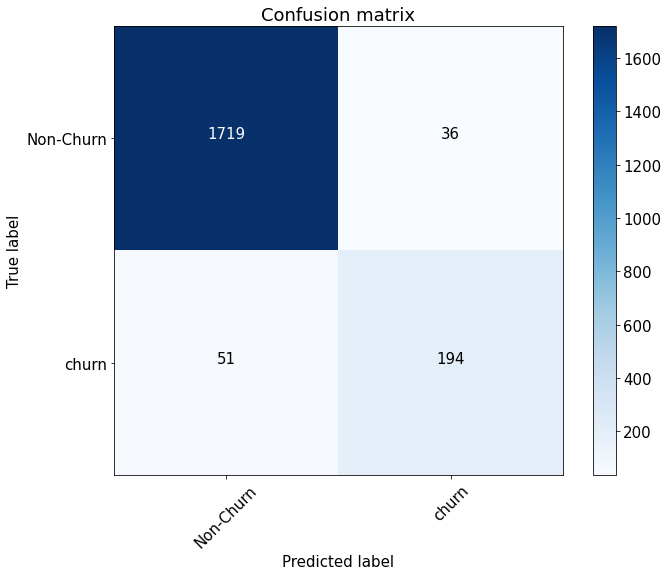

In [54]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_median_test, preds_median>thresholds_median[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
roc_auc_score_median = roc_auc_score(y_median_test, preds_median)
roc_auc_score_median

0.979489505203791

### Обучение модели на максимуме

In [56]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.324600,0.145705,0.054700,0.293078,0.000000,0.095300,0.267445,0.085562,0.000000,...,0.336589,0.157328,0.091271,0.020201,0.000000,0.000000,0.197068,0.291626,0.060706,0
1,u108690,0.100707,0.087381,0.112981,0.314253,0.054434,0.013254,0.326626,0.000000,0.000000,...,0.142485,0.149436,0.086759,0.000000,0.066153,0.053428,0.187789,0.074165,0.046048,1
2,u108339,0.080864,0.028395,0.154050,0.299975,0.010651,0.015582,0.270850,0.065911,0.054743,...,0.053443,0.156542,0.083345,0.172724,0.049939,0.000000,0.178892,0.104883,0.050923,1


In [57]:
#разделим данные на train/test
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [58]:
#обучим 
logreg_max = logreg.fit(X_max_train, y_max_train)

In [59]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]
preds_max[:10]

array([9.80019888e-02, 1.50179951e-04, 6.54324216e-01, 1.39837212e-01,
       1.74032680e-02, 2.15033351e-02, 5.40015811e-02, 2.20694493e-02,
       9.99798485e-02, 2.48534026e-01])

In [60]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.385472, F-Score=0.783, Precision=0.794, Recall=0.771


Confusion matrix, without normalization
[[1706   49]
 [  57  188]]


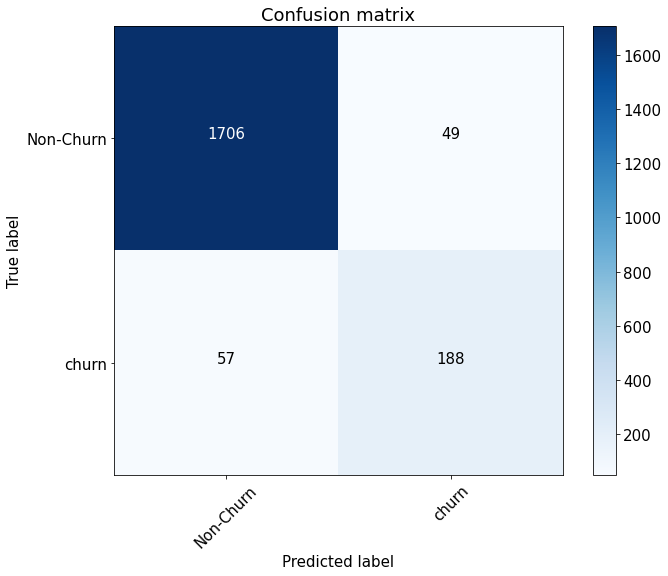

In [61]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_max_test, preds_max>thresholds_max[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [62]:
roc_auc_score_max = roc_auc_score(y_max_test, preds_max)
roc_auc_score_max

0.9754171754171754

In [ ]:
Вывод: по медиане roc auc выглядит чуть лучше, чем остальные методы - 0.9794